# Introduction
This report summurize the work on Dreem Deep Sleep Dataset for predicting power increase of a stimulation. it's organized in three parts: First, exploring the data, Second Some Feature Engineering and Third the predictions.

## Exploring the data
I have prepared some scripts to break down the data for easy visualisation, these scripts can be found attached to this notebook. I will just explore the results and comment them.

First let's import the libraries we're gonna need

In [2]:
import os
import os.path
import csv
from collections import OrderedDict
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

We're gonna define some High scope constants and functions that we're gonna use later on

In [3]:
RESULTS_TRAIN_DIR = 'results\\train'

def get_csv_file(filename):
    return os.path.join(RESULTS_TRAIN_DIR, filename)

def print_rslts(d):
    for k, v in d.items():
        print('{name}: {value}'.format(name=k, value=str(v)))

First of all, let's check the variable that we want to predict: `power_increase`

count: 50000.0
mean: 1.39000004214
std: 0.654845458744
min: 0.148209095001
25%: 0.938876867294
50%: 1.25051695108
75%: 1.68425995111
max: 8.46236896515


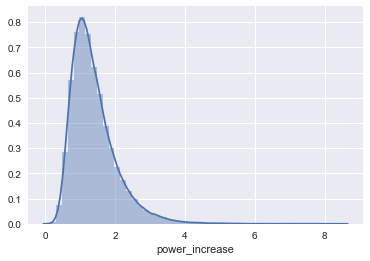

In [24]:
df = pd.read_csv(get_csv_file('power_increase.csv'))
df_summary = pd.read_csv(get_csv_file('power_increase_summury.csv'))
print_rslts({k: v for k, v in zip(df_summary.k, df_summary.power_increase)})
sns.distplot(df.power_increase)

MAX_POWER_INCREASE_INDEX = df.power_increase.argmax()
MIN_POWER_INCREASE_INDEX = df.power_increase.argmin()

This distribution of power increase is great because for our regression problem since there is only a neglegible amount of tailed data that stray far away from the mode. our calculation will not be very affected by these extreme cases, and we have a priori a suffucient number of samples to describe this phenomenon. Test Student

number of unique patients: 143
contribution of 20% of patients(28): 79.45%


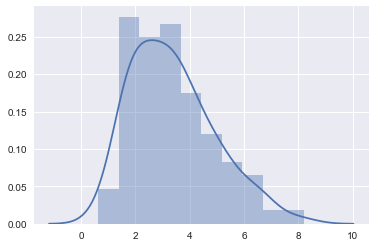

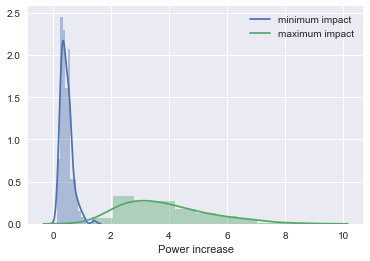

In [52]:
df = pd.read_csv(get_csv_file('user.csv'))
df_summary = pd.read_csv(get_csv_file('power_increase_by_user.csv'))
rslts = {}
rslts['number of unique patients'] = df.nunique()[0]
df_summary = df_summary.sort_values(by='count')
rslts['contribution of 20% of patients(28)'] = '{0:.2%}'.format(int(df_summary.iloc[-28:]['count'].sum()) / df_summary['count'].sum()) 
print_rslts(rslts)
sns.distplot(df_summary['max'] - df_summary['min'], axlabel=False, label='difference of impact by user')
plt.figure()
sns.distplot(df_summary['min'], kde_kws={"label": "minimum impact"})
sns.distplot(df_summary['max'], axlabel='Power increase', kde_kws={"label": "maximum impact"})

We can clearly see that we have a limited number of patients that verify pareto law. Means that only 28 patient contribute with almost 40,000 samples. Which may suggest that the power increase is more likely to depend on the patient. However the plot above almost rule out this possibility because almost each patient experience, what we can say, an effective stimulation and an ineffective stimulation.

It's safe at this stage to say that although the limited number of users, the results transcend the user.

We proceed with the same idea for the night, time before the stimulation, and number of stimulations before.

number of unique nights: 2096
std of samples per nights: 11.07


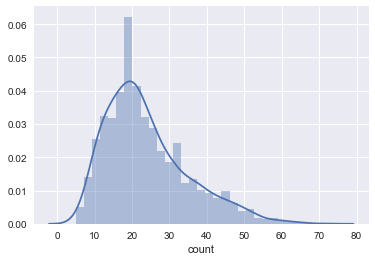

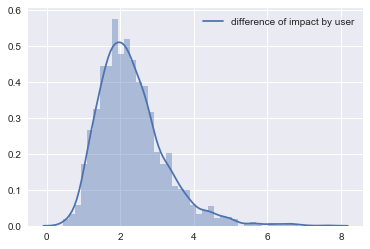

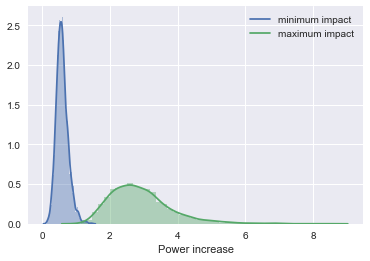

In [56]:
df = pd.read_csv(get_csv_file('night.csv'))
df_summary = pd.read_csv(get_csv_file('power_increase_by_night.csv'))
rslts = {}
rslts['number of unique nights'] = df.nunique()[0]
rslts['std of samples per nights'] = "{0:.2f}".format(df_summary['count'].std())
sns.distplot(df_summary.sort_values(by='count')['count'])
plt.figure()
print_rslts(rslts)
sns.distplot(df_summary['max'] - df_summary['min'], axlabel=False, kde_kws={"label": 'difference of impact by user'})
plt.figure()
sns.distplot(df_summary['min'], kde_kws={"label": "minimum impact"})
sns.distplot(df_summary['max'], axlabel='Power increase', kde_kws={"label": "maximum impact"})

We can assess the same type of results concerning the night feature with relatively high number of unique nights and low standard deviation. Therefore, we can rule out, at this stage the night from being a factor in the impact of stimulation (Like it can be !) 

Correlation between time_previous and power_increase: 4.59%
weight of less then 300 time_previous samples: 96.21%


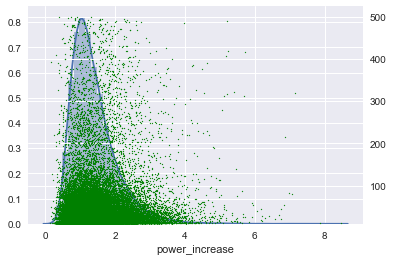

In [133]:
df = pd.read_csv(get_csv_file('time_previous.csv'))
df = pd.concat([pd.read_csv(get_csv_file('power_increase.csv')), df], axis=1)
df_summary = pd.read_csv(get_csv_file('time_previous_summury.csv'))
rslts = {}
rslts['Correlation between time_previous and power_increase'] = '{0:.2%}'.format(np.corrcoef(df.time_previous, df.power_increase)[0, 1])
f, ax1 = plt.subplots(1)
sns.distplot(df.power_increase)
df = df.query('0 < time_previous < 500')
rslts['weight of less then 300 time_previous samples'] = '{0:.2%}'.format(df.count()[0] / 50000)
ax2 = ax1.twinx()
ax2.scatter(df.power_increase, df.time_previous, s=1, color='g')
ax2.set_ylim(df.time_previous.min())
print_rslts(rslts)

For time

Correlation between time_previous and power_increase: 7.79%


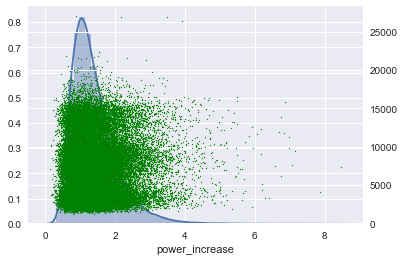

In [127]:
df = pd.read_csv(get_csv_file('time.csv'))
df = pd.concat([pd.read_csv(get_csv_file('power_increase.csv')), df], axis=1)
df_summary = pd.read_csv(get_csv_file('time_summury.csv'))
rslts = {}
rslts['Correlation between time_previous and power_increase'] = '{0:.2%}'.format(np.corrcoef(df.time, df.power_increase)[0, 1])
f, ax1 = plt.subplots(1)
sns.distplot(df.power_increase)
ax2 = ax1.twinx()
ax2.scatter(df.power_increase, df.time, s=1, color='g')
print_rslts(rslts)

In the following script we're going to analyze the main set of features (EEG signal). Intuitively, we think of plotting the eeg signal for the maximum impact and the eeg signal for the minimum impact.

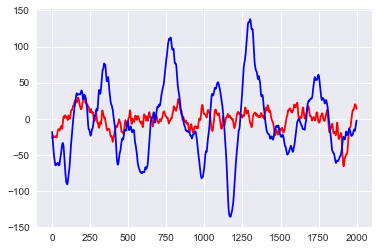

In [5]:
reader = csv.reader(open(get_csv_file('eeg.csv')))
pe = csv.reader(open(get_csv_file('power_increase.csv')))
next(reader) # Header
next(pe)
mx = 0.0
mx_r = []
mn = 10.0
mn_r = []
for row, pe in zip(reader, pe):
    pe = float(pe[0])
    mx = max(pe, mx)
    if mx == pe:
        mx_r = row
    mn = min(pe, mn)
    if mn == pe:
        mn_r = row
plt.plot(mx_r, color='r') #maximum impact
plt.plot(mn_r, color='b') #minimum impact
plt.show()

The results reveal some distinct characteristics of each signal:
1. ### Maximum impact
    * High frequency
    * Low energy
    * Low variance
2. ### Minimum impcat
    * Low frequency
    * High energy
    * High variance
    
These findings will certainly help us in the coming section, where we should extract the significan features from the eeg signal.